In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    when, countDistinct, count, avg,
    split, explode, trim, lit, length,
    current_date, row_number, regexp_replace,
    to_date, coalesce, col, when,
    year, month, dayofmonth, array_contains, min, max, year
)
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.window import Window
import numpy as np

In [0]:
# to read the data set with previous tranformations
df = spark.read.parquet("/FileStore/tables/Imdb_Movie_Dataset-4.csv")
display(df.limit(5))

id,title,vote_average,vote_count,status,revenue,runtime,adult,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,release_date,release_day,release_month,release_year
174104,The Spoilers,6.2,3,Released,4100000,110,false,0,tt0004630,en,The Spoilers,"The Spoilers is a 1914 film directed by Colin Campbell. It is set in Nome, Alaska during the 1898 Gold Rush, with William Farnum as Roy Glennister, Kathlyn Williams as Cherry Malotte, and Tom Santschi as Alex McNamara. The film culminates in a spectacular saloon fistfight between Glennister and McNamara. It was adapted to screen by Lanier Bartlett from the Rex Beach novel of the same name.",0.6,null,"Romance, Western",Selig Polyscope Company,United States of America,null,"alaska, silent film, nome alaska, saloon brawl, klondike gold rush, partially lost film",1914-10-04,4,10,1914
618,The Birth of a Nation,6.034,482,Released,11000000,193,false,100000,tt0004972,en,The Birth of a Nation,"Two families, abolitionist Northerners the Stonemans and Southern landowners the Camerons, intertwine. When Confederate colonel Ben Cameron is captured in battle, nurse Elsie Stoneman petitions for his pardon. In Reconstruction-era South Carolina, Cameron founds the Ku Klux Klan, battling Elsie's congressman father and his African-American protégé, Silas Lynch.",13.791,The Fiery Cross of the Ku Klux Klan!,"Drama, History, War",Epoch Film Co.,United States of America,No Language,"army, ku klux klan, southern usa, racist, silent film, american civil war, reconstruction era, controversial",1915-08-02,2,8,1915
70368,The Cheat,5.983,58,Released,137365,59,false,17311,tt0005078,en,The Cheat,"A venal, spoiled stockbroker's wife impulsively embezzles $10,000 from the charity she chairs and desperately turns to a Burmese ivory trader to replace the stolen money.",3.104,null,Drama,"Jesse L. Lasky Feature Play Company, Paramount",United States of America,No Language,null,1915-12-13,13,12,1915
30266,"20,000 Leagues Under the Sea",6.3,48,Released,8000000,85,false,200000,tt0006333,en,"20,000 Leagues Under the Sea","Captain Nemo has built a fantastic submarine for his mission of revenge. He has traveled over 20,000 leagues in search of Charles Denver - a man who caused the death of Princess Daaker. Seeing what he had done, Denver took the daughter to his yacht and sailed away.",3.474,The First Submarine Photoplay Ever Filmed,"Adventure, Drama, Action, Science Fiction",The Universal Film Mfg. Co.,"Bahamas, United States of America",English,"revenge, captain nemo",1916-12-24,24,12,1916
278480,A Daughter of the Gods,3.5,2,Released,1390000,180,false,1000000,tt0006568,en,A Daughter of the Gods,A sultan agrees to help an evil witch destroy a mysterious beauty if the witch will bring his young son back to life.,0.887,null,"Fantasy, Drama",Fox Film Corporation,United States of America,null,null,1916-10-16,16,10,1916


In [0]:
# how many rows do we have
total_rows = df.count()
print(f"Total rows in `df`: {total_rows}")

Total rows in `df`: 20442


In [0]:
# To check the type of each feature
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- budget: long (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- release_day: integer (nullable = true)
 |-- release_month: integer (nullable = true)
 |-- release_year: integer (nu

%md
## Categorical Feature Analysis

%md
All numerical variables have been analyzed.

%md
### TITLE

In [0]:
# Safe copy of the original DataFrame
df_copy3 = df.select("*")

In [0]:
# Count null, empty, and "None"/"none" titles
null_count = df_copy3.filter(col("title").isNull()).count()
empty_count = df_copy3.filter((col("title") == "") | (col("title") == " ")).count()
none_count = df_copy3.filter((col("title") == "None") | (col("title") == "none")).count()

print(f"Null titles: {null_count}")
print(f"Empty titles: {empty_count}")
print(f"None titles: {none_count}")

Null titles: 0
Empty titles: 0
None titles: 0


In [0]:
# Title length distribution
title_len_df = df_copy3.withColumn("title_length", length(col("title")))
min_len = title_len_df.agg({"title_length": "min"}).collect()[0][0]
max_len = title_len_df.agg({"title_length": "max"}).collect()[0][0]
median_len = title_len_df.approxQuantile("title_length", [0.5], 0.01)[0]
print(f"Title length — min: {min_len}, median: {median_len:.0f}, max: {max_len}")

# Show extremes
print("Longest titles:")
display(
    title_len_df
    .orderBy(col("title_length").desc())
    .select("id", "title", "title_length")
    .limit(5)
)
print("Shortest non-empty titles:")
display(
    title_len_df
    .filter(col("title").isNotNull() & (col("title") != ""))
    .orderBy(col("title_length").asc())
    .select("id", "title", "title_length")
    .limit(5)
)


Title length — min: 1, median: 14, max: 213
Longest titles:


id,title,title_length
989531,"Titanic Tits: Rural Cosplayer (Age 19) With A Submissive Streak (Everybody Gets A Titty & Nipple Fuck & Cums On Her Tits) P-Cup With Enormous Nipples Ravished By 12 Continuous Loads In A Titty Fuck Four-Some Orgy,",213
1375813,"At an idyllic writers retreat in Morocco, a newly single novelist finds an unexpected connection with a younger man who's reevaluating his life choices.",152
1043335,"120% of the time, you'll encounter a pervert! The AV debut of Iori Yugi, a wife with extra large 128 cm P-cup tits that will amaze anyone!",138
1042427,"Wife with super big nipples and P-cup breasts who has been raped for a long time, training and Nakadashi sexual intercourse, Iori Yuuki",135
1393343,Las espantosas aventuras de una rubia tonta y un valenciano de pueblo que se convierte en dinosaurio en un museo paleontológico 2,129


Shortest non-empty titles:


id,title,title_length
11065,O,1
373449,2,1
717807,G,1
1371237,b,1
1020263,I,1


%md
`title` column does not have any missing values and is stored with the correct data type. However, we noticed that some movies have titles consisting of only a single character. While this is unusual, it is not impossible in the context of cinema. Therefore, we will investigate this further to understand how many such cases exist in the dataset.

In [0]:
# Count the number of films with just one character as title
single_char_titles_count = df_copy3.filter(length(col("title")) == 1).count()

print(f"Number of movies with single-character titles: {single_char_titles_count}")

# display them
display(df_copy3.filter(length(col("title")) == 1).limit(5))

Number of movies with single-character titles: 12


id,title,vote_average,vote_count,status,revenue,runtime,adult,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,release_date,release_day,release_month,release_year
12244,9,6.907,3263,Released,48428063,79,false,30000000,tt0472033,en,9,"When 9 first comes to life, he finds himself in a post-apocalyptic world. All humans are gone, and it is only by chance that he discovers a small community of others like him taking refuge from fearsome machines that roam the earth intent on their extinction. Despite being the neophyte of the group, 9 convinces the others that hiding will do them no good.",24.562,When our world ended their mission began.,"Action, Adventure, Animation, Science Fiction, Thriller","Tim Burton Productions, Relativity Media, Arc Productions, Starz Animation, Focus Features","Canada, Luxembourg, United States of America",English,"friendship, man vs machine, hope, dystopia, post-apocalyptic future, steampunk, coward, end of world, rag doll",2009-08-19,19,8,2009
1061979,春,8.0,1,Released,100,null,false,100,tt1003137,zh,春,null,0.6,null,"Drama, Romance",中华联合制片公司,China,Mandarin,null,1942-01-01,1,1,1942
11065,O,5.811,236,Released,16017403,95,false,0,tt0184791,en,O,"Even though he's the only black student at the elite Palmetto Grove Academy, star basketball player and future NBA hopeful Odin James has the adoration of all, including the team's coach and the Dean's beautiful daughter Desi. Odin's troubled friend Hugo, the coach's son, is deeply resentful of his father's preference of Odin on and off the court. When Hugo plots a diabolical scheme to sow the seed of mistrust between O and Desi, it sets in motion a disturbing chain of events which erupts into a firestorm of breathtaking intensity.",10.449,Trust. Seduction. Betrayal.,"Drama, Romance, Thriller","Dimension Films, FilmEngine, Chickie The Cop Production, Daniel Fried Productions, Rhulen Entertainment",United States of America,"French, English","high school, jealousy, girlfriend, high school sports, friends, drugs, xenophobia, shakespeare in modern dress",2001-08-31,31,8,2001
36928,H,6.203,37,Released,438227,106,false,0,tt0304120,ko,에이치,"A notorious serial killer is finally arrested. But even as he is in custody, for some unknown reason, his killings continue outside.",2.916,You Can't Spell H-ell Without It.,"Drama, Thriller, Mystery",Bom Film Productions,South Korea,Korean,"detective, murder, cruelty",2002-12-26,26,12,2002
605802,8,6.146,72,Released,142725,99,false,0,tt7320482,en,8,"An old man, fated to collect souls for eternity, seeks atonement after trading his daughter's soul.",11.585,Fear the legend,Horror,Man Makes a Picture,South Africa,"English, Tswana",null,2020-03-13,13,3,2020


%md
Although it may seem unusual for a film to have a single-character title, we have decided to keep these entries in our dataset. Despite their atypical titles, these films contain relevant information for most of our features and therefore remain valuable for our analysis."

%md
### STATUS

%md
Let's check for distinct values 

In [0]:
# Count distinct non-null statuses
distinct_status_count = df_copy3.filter(col("status").isNotNull()).select("status").distinct().count()
print(f"Number of distinct 'status' values (excluding nulls): {distinct_status_count}")

# Show frequency of each status
status_counts = df_copy3.groupBy("status").count().orderBy(col("count").desc())
print("Counts per status:")
display(status_counts)

Number of distinct 'status' values (excluding nulls): 6
Counts per status:


status,count
Released,20305
In Production,90
Post Production,31
Planned,14
Rumored,1
Canceled,1


In [0]:
# Calculate average and median revenue by status
status_revenue_stats = (
    df_copy3
    .groupBy("status")
    .agg(
        F.avg("revenue").alias("average_revenue"),
        F.expr("percentile_approx(revenue, 0.5)").alias("median_revenue")
    )
    .orderBy("status")
)

# Display the results
display(status_revenue_stats)

status,average_revenue,median_revenue
Canceled,200.0,200
In Production,3.551619235555556E7,100
Planned,5270.214285714285,20
Post Production,9.887105564516129E7,196
Released,3.633014688214725E7,1850000
Rumored,162286.0,162286


In [0]:
total_count = df_copy3.count()
non_released_count = df_copy3.filter(col("status") != "Released").count()
percentage = (non_released_count / total_count) * 100

print(f"Non-released movies: {non_released_count} ({percentage:.2f}%)")

Non-released movies: 137 (0.67%)


In [0]:
# display them
display(df_copy3.filter(col("status") != "Released").limit(5))

id,title,vote_average,vote_count,status,revenue,runtime,adult,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,release_date,release_day,release_month,release_year
1116492,Dial,null,0,Post Production,5000,15,false,5000,tt27351080,en,Dial,"Dani cares for her ill mother who suddenly dies in her care. Shortly after her passing, Dani finds her mother's phone won't stop ringing.",1.088,Mother is calling,"Drama, Horror",Trett Films,United Kingdom,English,"psychological thriller, phone, carer",2023-10-31,31,10,2023
1063274,DOCSTRIKE🤓an Fatecs documentary,null,0,In Production,100,60,false,1000000,tt27654420,pt,Fatecs: Documentário de uma greve,"Discuss a strike and its benefits, for the community involved in its demands. Explain how the dialogue of a minority occurs, with the government entities, which in general are totally bureaucratic and infiltrated with vested interests and disconnected from their major users, such as students, the elderly, environmentalists, workers, among others.",0.6,a documentary of a strike,"Documentary, TV Movie, Music, History, Drama, Crime","CULTZONE Filmes, CULTZONE Studios","Brazil, India, Nigeria, United States of America","English, Portuguese",null,null,null,null,null
1122009,Septichexen,null,0,Post Production,10300,14,false,10300,tt27711687,no,Septichexen,"In the sewers of Bergen, a microbiologist tries to uncover a contamination of the drinking water. THE SEPTICHEXEN POEM: Deep below the city's streets, The witch in darkness waits and eats, Her magic seeps into the water's flow, As she seeks an heir to follow. Beware the witch with magic dread, Her lair of filth, her cauldron red, For she seeks a child to train in her way, And make the water turn foul each day. So do not stray too far below, Or the witch will catch you, don't you know? For in her realm, she rules supreme, And the darkness there will never beam.",1.386,Entombed in the veins of the sewer. A witch corrupting the city's lifeblood,"Horror, Science Fiction, Fantasy",ÅTSELFILM,Norway,Norwegian,"witch, contamination, water pollution, microbiology, witch legend",null,null,null,null
1331413,Ogees,null,0,Planned,50000,4,false,2000,tt33030393,en,Ogees,A short film about an aging artist displaying how to properly create a hip-hop track from scratch by using harmonies and creativity.,0.6,A short film about an aging artist displaying how to properly create a hip-hop track from scratch by using harmonies and creativity.,Music,Byrdee Entertainment,null,English,"hip-hop, microfilm, based on true story, singer-songwriter, freestyle, lyrics, real story, rap, short film, music, video editing, drama, ogees, n.o.k.",null,null,null,null
1146143,The Puppetman,null,0,In Production,1000000,null,false,0,tt19369162,en,The Puppetman,"The Puppetman, a convicted killer on death row always maintained his innocence and that it was an evil force controlling his body as he slaughtered his victims. Now Michal, the killer's daughter, begins to suspect that there may be some truth to her fathers claim when those around her begin to die in brutal ways. She must try and break the curse of The Puppetman before all her loved ones are killed.",3.346,You’re not in control.,Horror,Not The Funeral Home,United States of America,English,null,2023-12-22,22,12,2023


%md
These entries represent less than 1% of the dataset and contain incomplete or unreliable information for modeling. Since the goal is to analyze actual outcomes, we will retain only films with Released status.

In [0]:
# to remove these entries
df_copy3 = df_copy3.filter(col("status") == "Released")

%md
Since at this point all the movies in our dataset are already released,  which was our objective from the beginning,  this column becomes completely unnecessary as it now contains only a single unique value. Therefore, we will remove it from our DataFrame.

In [0]:
# to remove the column status
df_copy3 = df_copy3.drop("status")

# just to check
df_copy3.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- budget: long (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- release_day: integer (nullable = true)
 |-- release_month: integer (nullable = true)
 |-- release_year: integer (nullable = true)



%md
### ADULT

In [0]:
# Check distinct values in the "adult" column and count their occurrences
distinct_adult = df_copy3.groupBy("adult").count()

# Get the number of distinct values in the "adult" column
distinct_adult_count = distinct_adult.count()
print(f"Number of distinct values in 'adult': {distinct_adult_count}")

# Display the distinct values along with their counts
display(distinct_adult.limit(5))

Number of distinct values in 'adult': 2


adult,count
true,207
false,20098


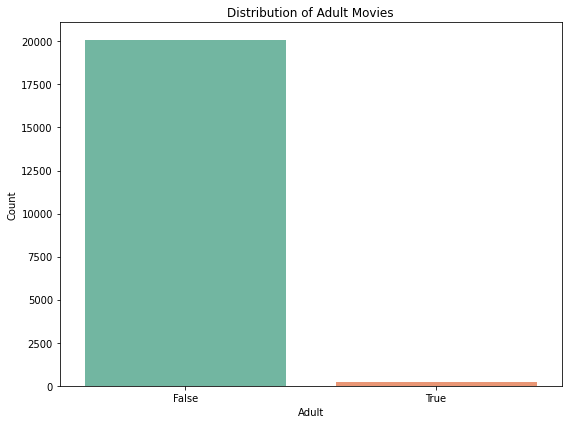

In [0]:
# Plot distribution of 'adult' values

# Count occurrences of each distinct value in 'adult' column
adult_distribution = df_copy3.groupBy("adult").count().toPandas()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x='adult', y='count', data=adult_distribution, palette='Set2')
plt.title('Distribution of Adult Movies')
plt.xlabel('Adult')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

%md
Overwhelming majority of the movies is **not** for adults only

%md
### ORIGINAL_LANGUAGE

In [0]:
# Summary of null, empty-string, "None"/"none", and zero counts for original_language
for cname in ["original_language"]:
    nulls   = df_copy3.filter(col(cname).isNull()).count()
    empties = df_copy3.filter((col(cname) == "") |(col(cname) == " ")).count()
    nones   = df_copy3.filter(col(cname).isin("None", "none")).count()
    zeros   = df_copy3.filter(col(cname) == "0").count()

    print(
        f"{cname}: nulls={nulls}, "
        f"empty strings={empties}, "
        f"'None'/'none' strings={nones}, "
        f"zero values={zeros}"
    )

original_language: nulls=0, empty strings=0, 'None'/'none' strings=0, zero values=0


In [0]:
# Print number of unique "original_language"
unique_lang_count = df_copy3.select("original_language").distinct().count()
print(f"Number of unique original_language: {unique_lang_count}")

Number of unique original_language: 90


In [0]:
# Print unique "original_language" values and their counts
df_copy3.groupBy("original_language") \
  .count() \
  .orderBy(col("count").desc()) \
  .show(90, False) # number of rows to display, turn off truncation to see full column values

+-----------------+-----+
|original_language|count|
+-----------------+-----+
|en               |13211|
|es               |944  |
|fr               |719  |
|zh               |550  |
|ru               |488  |
|ja               |484  |
|hi               |438  |
|pt               |400  |
|de               |320  |
|it               |320  |
|tr               |290  |
|ko               |263  |
|cn               |179  |
|ar               |158  |
|ml               |153  |
|fa               |137  |
|ta               |130  |
|nl               |93   |
|sv               |85   |
|te               |79   |
|th               |68   |
|da               |64   |
|ur               |61   |
|no               |52   |
|bn               |51   |
|id               |42   |
|vi               |40   |
|he               |37   |
|ro               |36   |
|tl               |36   |
|pl               |30   |
|kn               |30   |
|cs               |23   |
|pa               |23   |
|hu               |22   |
|ms         

%md
The listed short forms of languages refer to:
- **tn**: Tswana
- **zh**: Chinese
- **ko**: Korean
- **hi**: Hindi

https://www.science.co.il/language/Codes.php

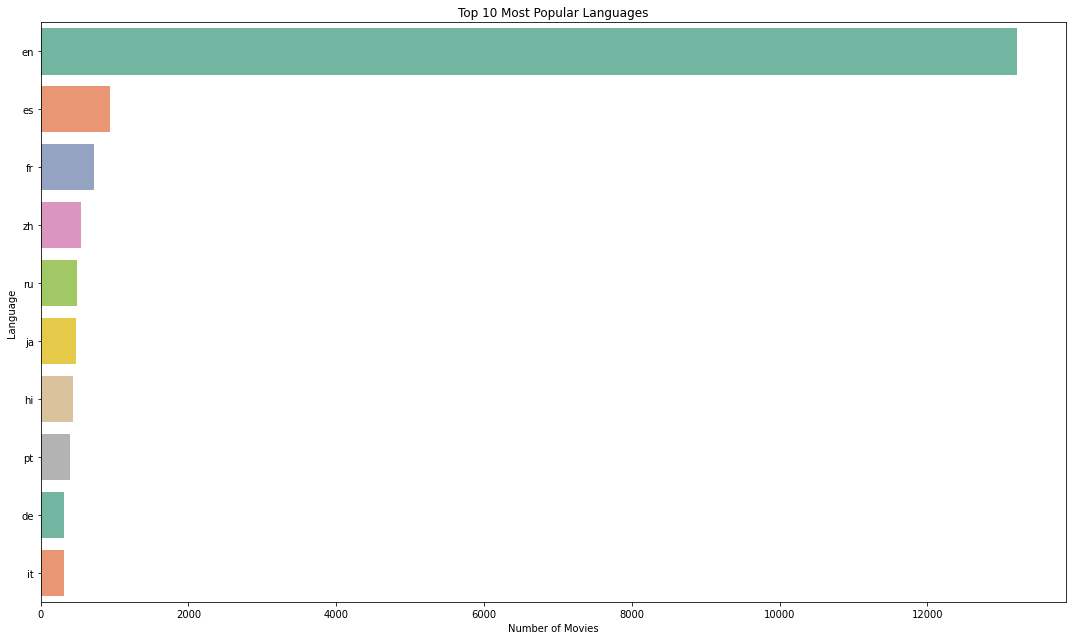

In [0]:
# Group by original_language and count occurrences
language_counts = df_copy3.groupBy("original_language").count().orderBy(col("count").desc())

# Show top 5 languages by count
top_languages = language_counts.limit(10).toPandas()

# Plot top 5 languages
plt.figure(figsize=(15, 9))
sns.barplot(x="count", y="original_language", data=top_languages, palette="Set2")
plt.title('Top 10 Most Popular Languages')
plt.xlabel('Number of Movies')
plt.ylabel('Language')
plt.tight_layout()
plt.show()

In [0]:
# Count the number of English-language movies
count_en = df_copy3.filter(col("original_language") == "en").count()

# Count the number of Spanish-language movies
count_es = df_copy3.filter(col("original_language") == "es").count()

# Calculate the percentage of Spanish movies compared to English
percentage_es_vs_en = (count_es / count_en) * 100

# Print the result
print(f"Spanish-language movies represent {percentage_es_vs_en:.2f}% of English-language movies.")

Spanish-language movies represent 7.15% of English-language movies.


%md
Great majority of the movies was filmed in english as the original language. To reduce cardinality we will create a new column `en_bool`, where 1 will denote the original language was english and 0 for other original language

In [0]:
# Create a boolean (0/1) column 'en_bool' for whether original_language == 'en'
df_copy3 = df_copy3.withColumn(
    "en_bool",
    when(col("original_language") == "en", lit(1)).otherwise(lit(0))
)

# Verify
df_copy3.select("original_language", "en_bool").show(10, False)

+-----------------+-------+
|original_language|en_bool|
+-----------------+-------+
|en               |1      |
|en               |1      |
|en               |1      |
|en               |1      |
|en               |1      |
|en               |1      |
|en               |1      |
|en               |1      |
|en               |1      |
|en               |1      |
+-----------------+-------+
only showing top 10 rows



In [0]:
# Compute distribution of values in "en_bool"
dist_df = df_copy3.groupBy("en_bool").count().orderBy("en_bool")

# Show the distribution counts
dist_df.show()

+-------+-----+
|en_bool|count|
+-------+-----+
|      0| 7094|
|      1|13211|
+-------+-----+



%md
We now have a variable that shows good balance and strong relevance for our predictive model.

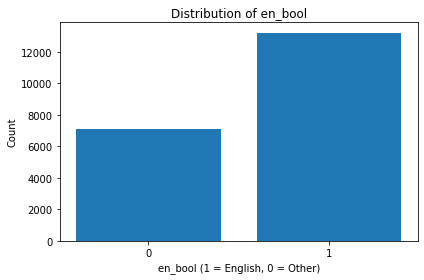

In [0]:
# Convert to Pandas for plotting
dist_pd = dist_df.toPandas()

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.bar(dist_pd["en_bool"].astype(str), dist_pd["count"])
plt.xlabel("en_bool (1 = English, 0 = Other)")
plt.ylabel("Count")
plt.title("Distribution of en_bool")
plt.tight_layout()
plt.show()

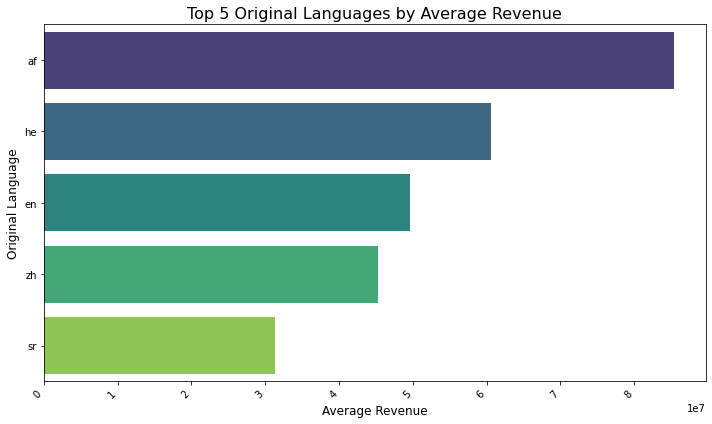

In [0]:
# Group by original_language and calculate the average revenue
language_revenue_avg = df_copy3.groupBy("original_language") \
    .agg(F.avg("revenue").alias("average_revenue"))

# Sort the languages by average revenue in descending order
language_revenue_avg = language_revenue_avg.orderBy(col("average_revenue").desc()).limit(5)

# Convert to Pandas for visualization
language_revenue_avg_pd = language_revenue_avg.toPandas()

# 4) Create a pretty bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="average_revenue", 
    y="original_language", 
    data=language_revenue_avg_pd, 
    palette="viridis"  # Color palette
)

# Add titles and labels for clarity
plt.title('Top 5 Original Languages by Average Revenue', fontsize=16)
plt.xlabel('Average Revenue', fontsize=12)
plt.ylabel('Original Language', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

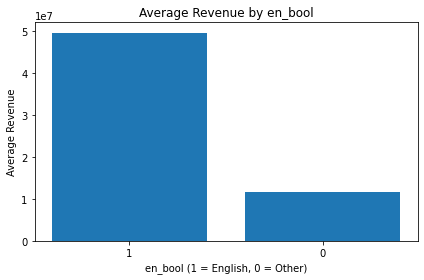

In [0]:
# Group by en_bool and compute average revenue
avg_rev_en = df_copy3.groupBy("en_bool").agg(F.avg("revenue").alias("average_revenue"))

# Convert to Pandas
avg_rev_en_pd = avg_rev_en.toPandas()

# Simple plot
plt.bar(avg_rev_en_pd["en_bool"].astype(str), avg_rev_en_pd["average_revenue"])
plt.xlabel("en_bool (1 = English, 0 = Other)")
plt.ylabel("Average Revenue")
plt.title("Average Revenue by en_bool")
plt.tight_layout()
plt.show()

%md
As expected, the majority of the movies are in English, which also explains the higher overall revenue associated with this language.

%md
### ORIGINAL_TITLE

In [0]:
# Count the total number of rows
total_rows = df_copy3.count()

# Count the number of rows where the original_title is different from title
different_titles_count = df_copy3.filter(col("original_title") != col("title")).count()

# Calculate the percentage of rows where original_title is different from title
percentage_different_titles = (different_titles_count / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"Number of movies with different 'original_title' than 'title': {different_titles_count}")
print(f"Percentage of movies with different titles: {percentage_different_titles:.2f}%")

Total rows: 20305
Number of movies with different 'original_title' than 'title': 4752
Percentage of movies with different titles: 23.40%


In [0]:
# Summary of null, empty-string, "None"/"none", and zero counts for 'original_title' column

nulls   = df_copy3.filter(col("original_title").isNull()).count()
empties = df_copy3.filter((col("original_title") == "") | (col("original_title") == " ")).count()
nones   = df_copy3.filter(col("original_title").isin("None", "none")).count()
zeros   = df_copy3.filter(col("original_title") == "0").count()

print(f"original_title: nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

original_title: nulls=0, empty strings=0, 'None'/'none' strings=0, zero values=0


In [0]:
# Add a column with the length of each original_title
df_length = df_copy3.withColumn("original_title_length", length(col("original_title")))

# Compute min, max, avg, and median of original_title_length
stats = (
    df_length
    .agg(
        F.min("original_title_length").alias("min_length"),
        F.max("original_title_length").alias("max_length"),
        F.avg("original_title_length").alias("avg_length"),
        F.expr("percentile_approx(original_title_length, 0.5)").alias("median_length")
    )
    .collect()[0]
)

min_length    = stats["min_length"]
max_length    = stats["max_length"]
avg_length    = stats["avg_length"]
median_length = stats["median_length"]

print(f"Shortest original_title length: {min_length}")
print(f"Longest original_title length : {max_length}")
print(f"Average original_title length : {avg_length:.1f}")
print(f"Median original_title length  : {median_length}")

# Show examples of the shortest and longest original_titles
print("Examples of shortest original_titles:")
display(
    df_length
      .filter(col("original_title_length") == min_length)
      .select("id", "title", "original_title", "original_title_length")
      .limit(5)
)

print("Examples of longest original_titles:")
display(
    df_length
      .filter(col("original_title_length") == max_length)
      .select("id", "title", "original_title", "original_title_length")
      .limit(5)
)


Shortest original_title length: 1
Longest original_title length : 152
Average original_title length : 15.8
Median original_title length  : 13
Examples of shortest original_titles:


id,title,original_title,original_title_length
11645,Ran,乱,1
1963,The Bow,활,1
12244,9,9,1
1061979,春,春,1
69502,Va,வ,1


Examples of longest original_titles:


id,title,original_title,original_title_length
1375813,"At an idyllic writers retreat in Morocco, a newly single novelist finds an unexpected connection with a younger man who's reevaluating his life choices.","At an idyllic writers retreat in Morocco, a newly single novelist finds an unexpected connection with a younger man who's reevaluating his life choices.",152


%md
This category has too much diversity and will not add meaningful value to our model or to the main objective of this project. We will remove it.

In [0]:
df_copy3 = df_copy3.drop("original_title")

%md
### OVERVIEW

In [0]:
# Summary of null, empty-string, "None"/"none", and zero counts for 'overview' column
total = df_copy3.count()

nulls   = df_copy3.filter(col("overview").isNull()).count()
empties = df_copy3.filter((col("overview") == "") | (col("overview") == " ")).count()
nones   = df_copy3.filter(col("overview").isin("None", "none")).count()
zeros   = df_copy3.filter(col("overview") == "0").count()

print(f"overview: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

overview: total=20305, nulls=1645, empty strings=0, 'None'/'none' strings=0, zero values=0


In [0]:
# Set those empty or whitespace-only overviews to null
df_copy3 = df_copy3.withColumn(
    "overview",
    when(trim(col("overview")) == "", None).otherwise(col("overview"))
)

# Then check again how many empty strings there are
empties = df_copy3.filter((col("overview") == "") |(col("overview") == " ")).count()
print(f"Number of empty strings left: {empties}")

Number of empty strings left: 0


In [0]:
# Add a column with the length of each overview
df_length = df_copy3.withColumn("overview_length", length(col("overview")))

# Compute min, max, avg, and median of overview_length
stats = (
    df_length
    .agg(
        F.min("overview_length").alias("min_length"),
        F.max("overview_length").alias("max_length"),
        F.avg("overview_length").alias("avg_length"),
        F.expr("percentile_approx(overview_length, 0.5)").alias("median_length")
    )
    .collect()[0]
)

min_length    = stats["min_length"]
max_length    = stats["max_length"]
avg_length    = stats["avg_length"]
median_length = stats["median_length"]

print(f"Shortest overview length: {min_length}")
print(f"Longest overview length : {max_length}")
print(f"Average overview length : {avg_length:.1f}")
print(f"Median overview length  : {median_length}")

# Show examples of the shortest and longest overviews
print("Examples of shortest overviews:")
display(
    df_length
      .filter(col("overview_length") == min_length)
      .select("id", "title", "overview", "overview_length")
      .limit(5)
)

print("Examples of longest overviews:")
display(
    df_length
      .filter(col("overview_length") == max_length)
      .select("id", "title", "overview", "overview_length")
      .limit(5)
)


Shortest overview length: 1
Longest overview length : 998
Average overview length : 274.9
Median overview length  : 235
Examples of shortest overviews:


id,title,overview,overview_length
1371237,b,x,1


Examples of longest overviews:


id,title,overview,overview_length
476292,Maquia: When the Promised Flower Blooms,"Maquia is a member of a special race called the Iorph who can live for hundreds of years. However, Maquia has always felt lonely despite being surrounded by her people, as she was orphaned from a young age. She daydreams about the outside world, but dares not travel from her home due to the warnings of the clan's chief. One day the kingdom of Mezarte invades her homeland. They already have what is left of the giant dragons, the Renato, under their control, and now their king wishes to add the immortality to his bloodline. They ravage the Iorph homeland and kill most of its inhabitants. Caught in the midst of the attack, Maquia is carried off by one of the Renato. It soon dies, and she is left deserted in a forest, now truly alone save for the cries of a single baby off in the distance. Maquia finds the baby in a destroyed village and decides to raise him as her own, naming him Ariel. Although she knows nothing of the human world, how to raise a child that ages much faster than her.",998


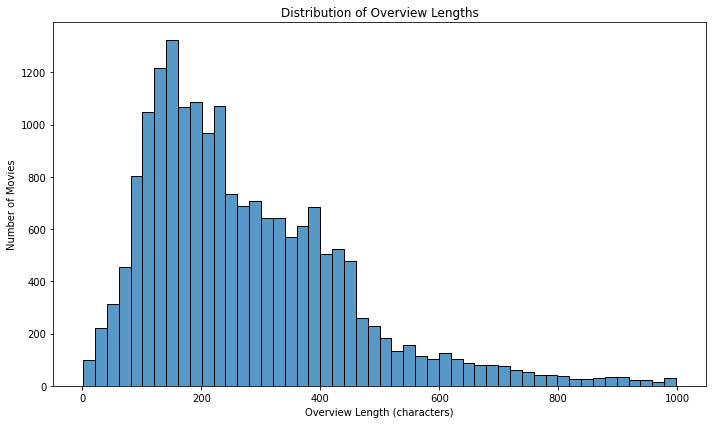

In [0]:
# Plot the distribution of overview lengths
overview_lengths_pd = df_length.select("overview_length").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(overview_lengths_pd["overview_length"], bins=50, kde=False)
plt.title("Distribution of Overview Lengths")
plt.xlabel("Overview Length (characters)")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

%md
Distribution of overview leghts is right skewed. It indicates that most overviews have around 150 words. Only some have the maximum number of 998 characters.

In [0]:
df_copy3 = df_copy3.drop("overview_length")

%md
### TAGLINE

%md
The column `tagline` has the correct data type - string. Let's investigate this feature:

In [0]:
# Summary for 'tagline'
total = df_copy3.count()

nulls   = df_copy3.filter(col("tagline").isNull()).count()
empties = df_copy3.filter((col("tagline") == "") | (col("tagline") == " ")).count()
nones   = df_copy3.filter(col("tagline").isin("None", "none")).count()
zeros   = df_copy3.filter(col("tagline") == "0").count()

print(f"tagline: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

tagline: total=20305, nulls=7221, empty strings=0, 'None'/'none' strings=1, zero values=0


In [0]:
# Replace "None"/"none" in `tagline` with null

# Count before replacement
none_count = df.filter(col("tagline").isin("None", "none")).count()
print(f"Taglines with 'None' or 'none' before cleanup: {none_count}")

# Perform replacement
df = df.withColumn(
    "tagline",
    when(col("tagline").isin("None", "none"), None).otherwise(col("tagline"))
)

# Verify post-replacement
post_none_count = df.filter(col("tagline").isNull()).count()
print(f"Taglines null after cleanup: {post_none_count}")

Taglines with 'None' or 'none' before cleanup: 1
Taglines null after cleanup: 7278


In [0]:
# Compute min, max, average, and median lengths of `tagline`
from pyspark.sql.functions import length, avg, expr, min as spark_min, max as spark_max

df_length = df_copy3.withColumn("tagline_length", length(col("tagline")))

stats = df_length.agg(
    spark_min("tagline_length").alias("min_length"),
    spark_max("tagline_length").alias("max_length"),
    avg("tagline_length").alias("avg_length"),
    expr("percentile_approx(tagline_length, 0.5)").alias("median_length")
).collect()[0]

print(f"Shortest tagline: {stats['min_length']}")
print(f"Longest  tagline: {stats['max_length']}")
print(f"Average  tagline: {stats['avg_length']:.1f}")
print(f"Median   tagline: {stats['median_length']}")

Shortest tagline: 1
Longest  tagline: 248
Average  tagline: 42.0
Median   tagline: 36


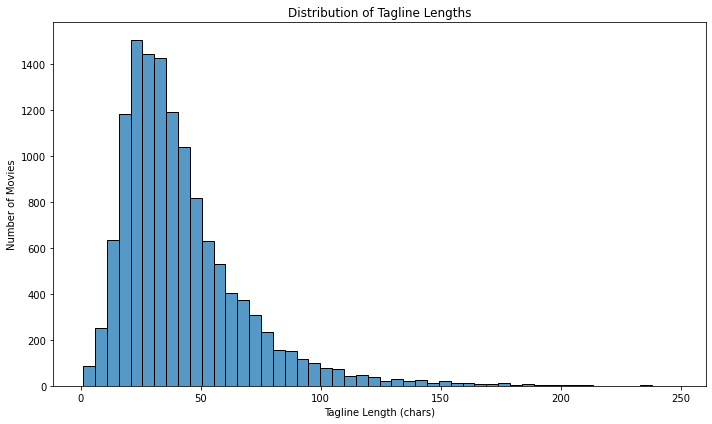

In [0]:
# Plot distribution of tagline lengths
# Convert to Pandas
lengths_pd = df_length.select("tagline_length").toPandas()["tagline_length"].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(lengths_pd, bins=50, kde=False)
plt.title("Distribution of Tagline Lengths")
plt.xlabel("Tagline Length (chars)")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

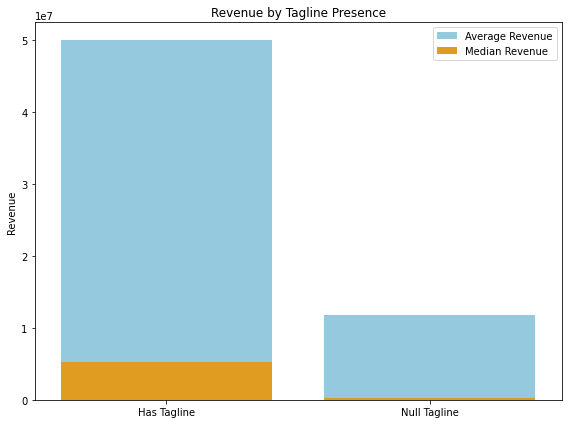

In [0]:
# Compare average revenue: tagline NULL vs non-NULL
# Compute stats
rev_stats = (
    df.groupBy(col("tagline").isNull().alias("tagline_null"))
      .agg(
          F.avg("revenue").alias("avg_revenue"),
          F.expr("percentile_approx(revenue, 0.5)").alias("median_revenue")
      )
      .orderBy("tagline_null")
      .toPandas()
)

# Map boolean to labels
rev_stats["tagline_null"] = rev_stats["tagline_null"].map({True: "Null Tagline", False: "Has Tagline"})

plt.figure(figsize=(8, 6))
sns.barplot(x="tagline_null", y="avg_revenue", data=rev_stats, color="skyblue", label="Average Revenue", ci=None)
sns.barplot(x="tagline_null", y="median_revenue", data=rev_stats, color="orange", label="Median Revenue", ci=None)
plt.title("Revenue by Tagline Presence")
plt.xlabel("")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()

%md
To reduce complexity of this variable we will create a boolean feature "tagline_bool", for which value 1 will denote that the tagline was present and 0 for null taglines

In [0]:
# Create boolean column from "tagline" (0 if null, 1 if not)
df_copy3 = df_copy3.withColumn(
    "tagline_bool",
    when(col("tagline").isNull(), lit(0)).otherwise(lit(1))
)

+------------+-----+
|tagline_bool|count|
+------------+-----+
|           0| 7221|
|           1|13084|
+------------+-----+



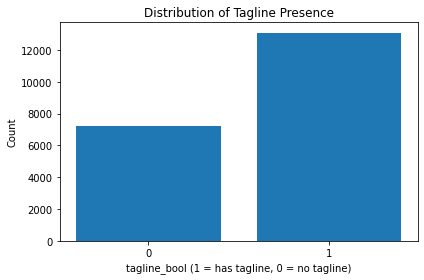

In [0]:
# Show counts of tagline_bool values
df_copy3.groupBy("tagline_bool") \
  .count() \
  .orderBy("tagline_bool") \
  .show()

#  Convert to Pandas for plotting
dist_pd = (
    df_copy3.groupBy("tagline_bool")
      .count()
      .orderBy("tagline_bool")
      .toPandas()
)

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.bar(dist_pd["tagline_bool"].astype(str), dist_pd["count"])
plt.xlabel("tagline_bool (1 = has tagline, 0 = no tagline)")
plt.ylabel("Count")
plt.title("Distribution of Tagline Presence")
plt.tight_layout()
plt.show()

%md
Now that the `tagline` feature has been converted to a boolean, it becomes useful for our predictive model

%md
### GENRES

In [0]:
# Summary for 'genres'
total = df_copy3.count()

nulls   = df_copy3.filter(col("genres").isNull()).count()
empties = df_copy3.filter((col("genres") == "") | (col("genres") == " ")).count()
nones   = df_copy3.filter(col("genres").isin("None", "none")).count()
zeros   = df_copy3.filter(col("genres") == "0").count()

print(f"genres: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

genres: total=20305, nulls=1868, empty strings=0, 'None'/'none' strings=0, zero values=0


In [0]:
df_copy3.select("genres").show(50, truncate=False)

+-----------------------------------------+
|genres                                   |
+-----------------------------------------+
|Romance, Western                         |
|Drama, History, War                      |
|Drama                                    |
|Adventure, Drama, Action, Science Fiction|
|Fantasy, Drama                           |
|Fantasy, Animation                       |
|Drama, Romance                           |
|Drama, Crime                             |
|Comedy, Drama                            |
|Drama, Thriller                          |
|Romance, Adventure, Fantasy              |
|Drama, History, War                      |
|null                                     |
|Adventure, Comedy, Drama                 |
|Western                                  |
|Comedy                                   |
|null                                     |
|Drama                                    |
|Adventure, Drama, Romance                |
|Comedy, Drama, War             

In [0]:
# Count occurrences of each distinct genre
# Split the comma-separated string into an array, trimming whitespace
df_copy3 = df_copy3.withColumn(
    "genres_array",
    split(col("genres"), "\\s*,\\s*")
)

# Explode the array so each genre gets its own row
genres_exploded = df_copy3.select(
    explode(col("genres_array")).alias("genre")
)

# Group by the individual genre values and count
genres_exploded.groupBy("genre") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(100, False)  # adjust the number 100 if you want more or fewer rows

# Count the number of distinct genres
distinct_genre_count = genres_exploded.select("genre").distinct().count()
print(f"Number of distinct genres: {distinct_genre_count}")

+---------------+-----+
|genre          |count|
+---------------+-----+
|Drama          |8614 |
|Comedy         |6346 |
|Action         |3689 |
|Thriller       |3651 |
|Romance        |3152 |
|Adventure      |2326 |
|Crime          |2285 |
|Horror         |2044 |
|Family         |1585 |
|Science Fiction|1409 |
|Fantasy        |1400 |
|Mystery        |1333 |
|Animation      |1108 |
|Documentary    |992  |
|History        |807  |
|Music          |796  |
|War            |566  |
|Western        |246  |
|TV Movie       |76   |
+---------------+-----+

Number of distinct genres: 19


In [0]:
# Handle "genres" for boolean columns
# Explode into individual genres and plot top 10 by total revenue
df_copy3 = df_copy3.withColumn(
    "genres_array",
    split(regexp_replace(col("genres"), "\\s*,\\s*", ","), ",")
)

genre_rev_df = (
    df_copy3.select(explode(col("genres_array")).alias("genre"), col("revenue"))
      .groupBy("genre")
      .agg(spark_sum("revenue").alias("total_revenue"))
      .orderBy(col("total_revenue").desc())
)

genre_rev_df.show(10)

+---------------+-------------+
|          genre|total_revenue|
+---------------+-------------+
|         Action| 282432025054|
|      Adventure| 267454889955|
|         Comedy| 246958992459|
|          Drama| 226068012607|
|       Thriller| 154715164505|
|Science Fiction| 133176106684|
|        Fantasy| 132107758046|
|         Family| 130657510418|
|        Romance|  99166729571|
|      Animation|  91857566850|
+---------------+-------------+
only showing top 10 rows



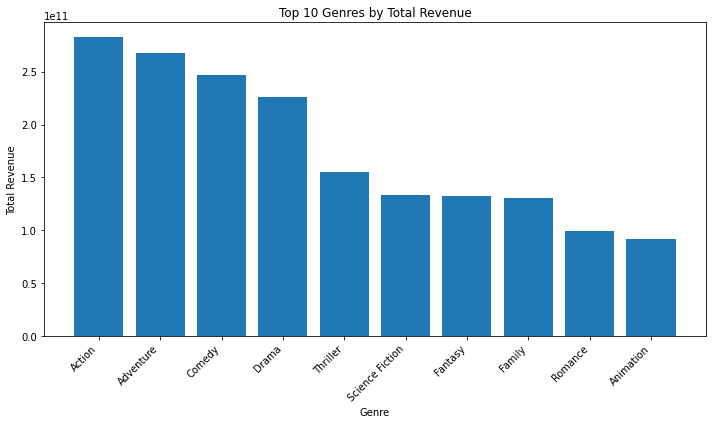

In [0]:
top10_genres = genre_rev_df.limit(10).toPandas()
plt.figure(figsize=(10,6))
plt.bar(top10_genres["genre"], top10_genres["total_revenue"])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Genres by Total Revenue")
plt.xlabel("Genre")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

%md
Here we can clearly observe that the genres contributing to higher movie revenue are Action, Adventure, Comedy, and Drama, standing out significantly from the rest.

%md
To simplify this variable and make it more usable, we will transform it into six possible boolean combinations based on the five most common genres. If none of these genres are present (i.e., all five are set to 0), the movie will be classified as belonging to one of the remaining, less frequent genres.

In [0]:
# Create boolean columns for top 5 most profitable genres
top5_genres = [row["genre"] for row in genre_rev_df.limit(5).collect()]
for g in top5_genres:
    col_name = g.lower().replace(" ", "_")
    df_copy3 = df_copy3.withColumn(
        col_name,
        when(array_contains(col("genres_array"), g), lit(1)).otherwise(lit(0))
    )

Boolean columns for top 5 genres: ['action', 'adventure', 'comedy', 'drama', 'thriller']
+------+---------+------+-----+--------+
|action|adventure|comedy|drama|thriller|
+------+---------+------+-----+--------+
|0     |0        |0     |0    |0       |
|0     |0        |0     |1    |0       |
|0     |0        |0     |1    |0       |
|1     |1        |0     |1    |0       |
|0     |0        |0     |1    |0       |
|0     |0        |0     |0    |0       |
|0     |0        |0     |1    |0       |
|0     |0        |0     |1    |0       |
|0     |0        |1     |1    |0       |
|0     |0        |0     |1    |1       |
+------+---------+------+-----+--------+
only showing top 10 rows



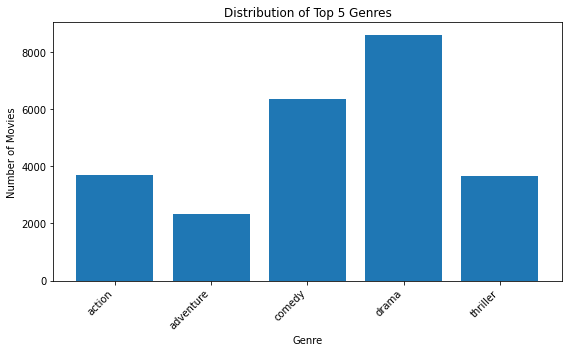

In [0]:
# recover the list of boolean columns
bool_cols   = [g.lower().replace(" ", "_") for g in top5_genres]

# View the first 10 rows of those boolean columns
print("Boolean columns for top 5 genres:", bool_cols)
df_copy3.select(bool_cols).show(10, False)

# Count how many movies have each genre (sum of the 1s)
counts_df = df_copy3.select([spark_sum(col(c)).alias(c) for c in bool_cols]) \
              .toPandas() \
              .melt(var_name="genre", value_name="count")

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.bar(counts_df["genre"], counts_df["count"])
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.title("Distribution of Top 5 Genres")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

%md
From this chart, and based on what we already knew, we can see that the Adventure genre, although it is the least represented among the five most popular genres in our dataset, ends up having the second highest average revenue. This highlights its strong impact on box office performance.

%md
### PRODUCTION_COMPANIES

In [0]:
# Summary for 'production_companies'
total = df_copy3.count()

nulls   = df_copy3.filter(col("production_companies").isNull()).count()
empties = df_copy3.filter((col("production_companies") == "") | (col("production_companies") == " ")).count()
nones   = df_copy3.filter(col("production_companies").isin("None", "none")).count()
zeros   = df_copy3.filter(col("production_companies") == "0").count()

print(f"production_companies: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

production_companies: total=20305, nulls=3589, empty strings=0, 'None'/'none' strings=0, zero values=0


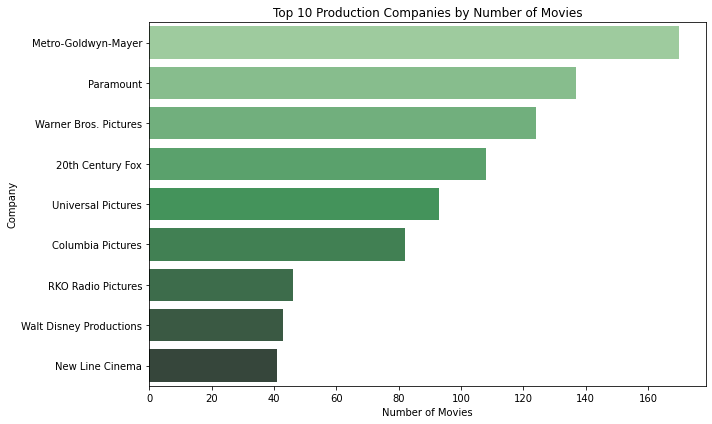

In [0]:
# Top 10 production_companies by number of movies
company_counts = (
    df_copy3
    .groupBy("production_companies")
    .count()
    .orderBy(col("count").desc())
    .limit(10)
    .toPandas()
)

plt.figure(figsize=(10,6))
sns.barplot(x="count", y="production_companies", data=company_counts, palette="Greens_d")
plt.title("Top 10 Production Companies by Number of Movies")
plt.xlabel("Number of Movies")
plt.ylabel("Company")
plt.tight_layout()
plt.show()


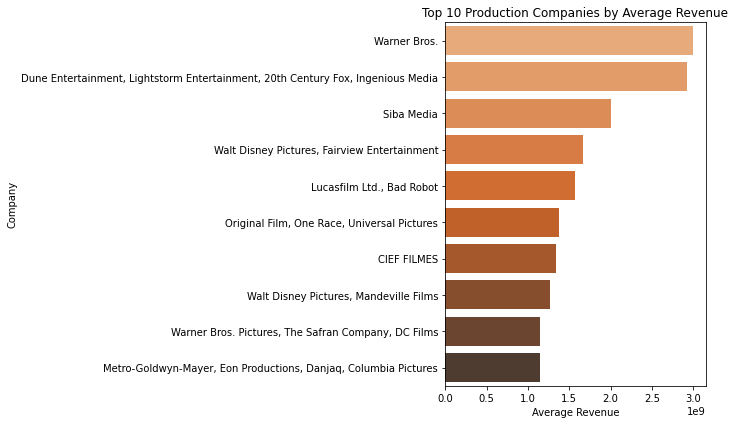

In [0]:
# Top 10 production_companies by average revenue

company_revenue = (
    df_copy3
    .groupBy("production_companies")
    .agg(avg("revenue").alias("avg_revenue"))
    .orderBy(col("avg_revenue").desc())
    .limit(10)
    .toPandas()
)

plt.figure(figsize=(10,6))
sns.barplot(x="avg_revenue", y="production_companies", data=company_revenue, palette="Oranges_d")
plt.title("Top 10 Production Companies by Average Revenue")
plt.xlabel("Average Revenue")
plt.ylabel("Company")
plt.tight_layout()
plt.show()


%md
From these two charts, it is easy to see that the number of films produced does not necessarily reflect quality or success. For example, Metro-Goldwyn-Mayer is the company with the highest number of productions, yet when looking at the top 10 production companies by revenue, it ranks only 10th. This highlights the discrepancy between quantity and profitability.

%md
There are many high-cardinality cells in `production_companies`. Therefore, we will create boolean columns, for the top 6 most profitable ones

In [0]:
# Split & explode high‐cardinality “production_companies”
df_copy3 = df_copy3.withColumn(
    "prod_companies_array",
    split(
        regexp_replace(col("production_companies"), r"\s*,\s*", ","),  # normalize commas
        ","
    )
)
prod_exploded = df_copy3.select(
    explode(col("prod_companies_array")).alias("company"),
    col("revenue")
)

In [0]:
# Count occurrences & distinct count
prod_counts = (
    prod_exploded
      .groupBy("company")
      .count()
      .orderBy(col("count").desc())
)
prod_counts.show(10, False)  # show top 10 by frequency
print(f"Number of distinct production companies: {prod_counts.count()}")

+---------------------+-----+
|company              |count|
+---------------------+-----+
|Warner Bros. Pictures|731  |
|Universal Pictures   |673  |
|Paramount            |547  |
|20th Century Fox     |543  |
|Columbia Pictures    |515  |
|Metro-Goldwyn-Mayer  |429  |
|Canal+               |283  |
|New Line Cinema      |247  |
|Walt Disney Pictures |208  |
|Miramax              |197  |
+---------------------+-----+
only showing top 10 rows

Number of distinct production companies: 16600


+---------------------+-------------+
|company              |total_revenue|
+---------------------+-------------+
|Universal Pictures   |72870870868  |
|Warner Bros. Pictures|70326812138  |
|20th Century Fox     |61671627134  |
|Paramount            |57149105804  |
|Columbia Pictures    |56800655811  |
|Walt Disney Pictures |50143842107  |
|New Line Cinema      |25076803075  |
|Marvel Studios       |24311179768  |
|Metro-Goldwyn-Mayer  |21192895081  |
|DreamWorks Pictures  |20073233797  |
+---------------------+-------------+



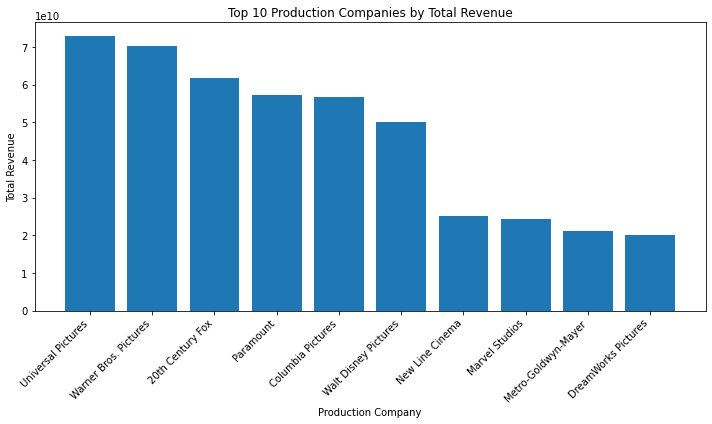

In [0]:
# Top 10 companies by total revenue & plot
prod_rev = (
    prod_exploded
      .groupBy("company")
      .agg(spark_sum("revenue").alias("total_revenue"))
      .orderBy(col("total_revenue").desc())
)
top10_prod = prod_rev.limit(10)
top10_prod.show(10, False)

# Plot
pd_top10_prod = top10_prod.toPandas()
plt.figure(figsize=(10,6))
plt.bar(pd_top10_prod["company"], pd_top10_prod["total_revenue"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Production Companies by Total Revenue")
plt.xlabel("Production Company")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

In [0]:
# Create boolean flags for the top 6 most profitable companies
top6_prod = [row["company"] for row in prod_rev.limit(6).collect()]
for comp in top6_prod:
    flag_col = comp.lower().replace(" ", "_").replace(".", "").replace(",", "")
    df_copy3 = df_copy3.withColumn(
        flag_col,
        when(array_contains(col("prod_companies_array"), comp), 1).otherwise(0)
    )

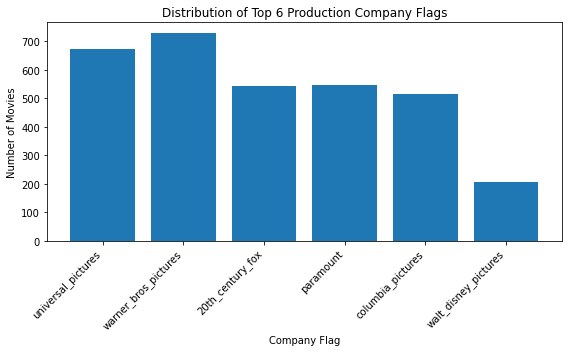

In [0]:
# Plot distribution of these boolean flags
bool_cols_prod = [c.lower().replace(" ", "_").replace(".", "").replace(",", "") for c in top6_prod]
dist_prod = (
    df_copy3
      .select([spark_sum(col(c)).alias(c) for c in bool_cols_prod])
      .toPandas()
      .melt(var_name="company", value_name="count")
)
plt.figure(figsize=(8,5))
plt.bar(dist_prod["company"], dist_prod["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Top 6 Production Company Flags")
plt.ylabel("Number of Movies")
plt.xlabel("Company Flag")
plt.tight_layout()
plt.show()

%md
For this variable to become useful for our model, it also needs to be converted into a binary system of 6 categories, representing the top 5 production companies by revenue, plus one additional category for all others.

%md
### PRODUCTION_COUNTRIES

In [0]:
# Summary for 'production_countries'
total = df_copy3.count()

nulls   = df_copy3.filter(col("production_countries").isNull()).count()
empties = df_copy3.filter((col("production_countries") == "") | (col("production_countries") == " ")).count()
nones   = df_copy3.filter(col("production_countries").isin("None", "none")).count()
zeros   = df_copy3.filter(col("production_countries") == "0").count()

print(f"production_countries: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

production_countries: total=20305, nulls=3136, empty strings=0, 'None'/'none' strings=0, zero values=0


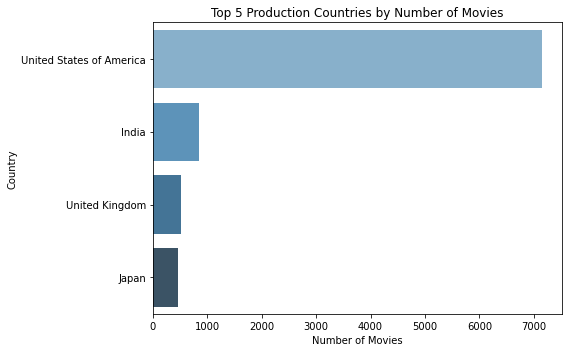

In [0]:
# Top 5 production_countries by number of movies

country_counts = (
    df_copy3
    .groupBy("production_countries")
    .count()
    .orderBy(col("count").desc())
    .limit(5)
    .toPandas()
)

plt.figure(figsize=(8,5))
sns.barplot(x="count", y="production_countries", data=country_counts, palette="Blues_d")
plt.title("Top 5 Production Countries by Number of Movies")
plt.xlabel("Number of Movies")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

%md
It is easy to observe that the United States is the largest producer of films. To make this variable useful for our model, we will also convert it into a binary system of five categories, representing the top film-producing countries

%md
### SPOKEN_LANGUAGES

In [0]:
# Summary for 'spoken_languages'
total = df_copy3.count()

nulls   = df_copy3.filter(col("spoken_languages").isNull()).count()
empties = df_copy3.filter((col("spoken_languages") == "") | (col("spoken_languages") == " ")).count()
nones   = df_copy3.filter(col("spoken_languages").isin("None", "none")).count()
zeros   = df_copy3.filter(col("spoken_languages") == "0").count()

print(f"spoken_languages: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

spoken_languages: total=20305, nulls=2562, empty strings=0, 'None'/'none' strings=0, zero values=0


In [0]:
# Display distinct languages
display(
    df_copy3
      .select("spoken_languages")
      .distinct()
      .orderBy("spoken_languages")
      .limit(10)
)

spoken_languages
null
Abkhazian
"Abkhazian, French, Georgian, English, Russian, Hungarian"
Afar
Afrikaans
"Afrikaans, Chichewa; Nyanja, Sotho, Xhosa, Zulu, English"
"Afrikaans, English"
"Afrikaans, English, Sotho, Tswana, Zulu"
"Afrikaans, English, Tswana"
"Afrikaans, English, Xhosa"


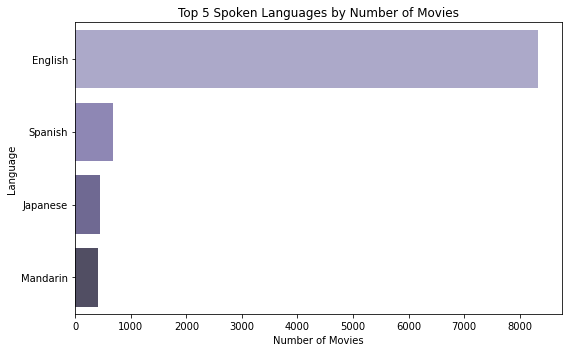

In [0]:
# Top 5 spoken_languages by number of movies
lang_counts = (
    df_copy3
    .groupBy("spoken_languages")
    .count()
    .orderBy(col("count").desc())
    .limit(5)
    .toPandas()
)

plt.figure(figsize=(8,5))
sns.barplot(x="count", y="spoken_languages", data=lang_counts, palette="Purples_d")
plt.title("Top 5 Spoken Languages by Number of Movies")
plt.xlabel("Number of Movies")
plt.ylabel("Language")
plt.tight_layout()
plt.show()

%md
For this variable as well, we will create a binary system with five elements, representing the four most frequent values along with one additional category for all remaining cases

%md
### KEYWORDS

In [0]:
# Summary for 'keywords'
total = df_copy3.count()

nulls   = df_copy3.filter(col("keywords").isNull()).count()
empties = df_copy3.filter((col("keywords") == "") | (col("keywords") == " ")).count()
nones   = df_copy3.filter(col("keywords").isin("None", "none")).count()
zeros   = df_copy3.filter(col("keywords") == "0").count()

print(f"keywords: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

keywords: total=20305, nulls=5484, empty strings=0, 'None'/'none' strings=0, zero values=0


In [0]:
# Split & explode “keywords”
df_copy3 = df_copy3.withColumn(
    "keywords_array",
    split(
        regexp_replace(col("keywords"), r"\s*,\s*", ","), 
        ","
    )
)
kw_exploded = df_copy3.select(
    explode(col("keywords_array")).alias("keyword"),
    col("revenue")
)

In [0]:
# Count occurrences & distinct count
kw_counts = (
    kw_exploded
      .groupBy("keyword")
      .count()
      .orderBy(col("count").desc())
)
kw_counts.show(10, False)
print(f"Number of distinct keywords: {kw_counts.count()}")


+----------------------+-----+
|keyword               |count|
+----------------------+-----+
|based on novel or book|1178 |
|woman director        |900  |
|murder                |715  |
|new york city         |628  |
|california            |497  |
|based on true story   |464  |
|revenge               |456  |
|duringcreditsstinger  |442  |
|sequel                |424  |
|biography             |409  |
+----------------------+-----+
only showing top 10 rows

Number of distinct keywords: 19251


+----------------------+-------------+
|keyword               |total_revenue|
+----------------------+-------------+
|duringcreditsstinger  |85603738694  |
|based on novel or book|84279263719  |
|sequel                |82735878846  |
|based on comic        |62286966735  |
|aftercreditsstinger   |61887138713  |
|superhero             |54995517403  |
|new york city         |42168491189  |
|california            |39122969860  |
|friendship            |27344158099  |
|revenge               |26598612228  |
+----------------------+-------------+



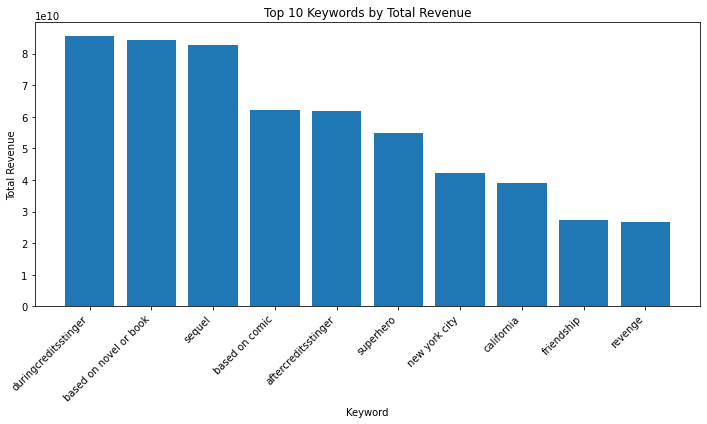

In [0]:
# Top 10 keywords by total revenue & plot
kw_rev = (
    kw_exploded
      .groupBy("keyword")
      .agg(spark_sum("revenue").alias("total_revenue"))
      .orderBy(col("total_revenue").desc())
)
top10_kw = kw_rev.limit(10)
top10_kw.show(10, False)

pd_top10_kw = top10_kw.toPandas()
plt.figure(figsize=(10,6))
plt.bar(pd_top10_kw["keyword"], pd_top10_kw["total_revenue"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Keywords by Total Revenue")
plt.xlabel("Keyword")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

In [0]:
# Boolean flags for the top 3 most profitable keywords
top3_kw = [row["keyword"] for row in kw_rev.limit(3).collect()]
for kw in top3_kw:
    flag_col = kw.lower().replace(" ", "_").replace(".", "").replace(",", "")
    df_copy3 = df_copy3.withColumn(
        flag_col,
        when(array_contains(col("keywords_array"), kw), 1).otherwise(0)
    )

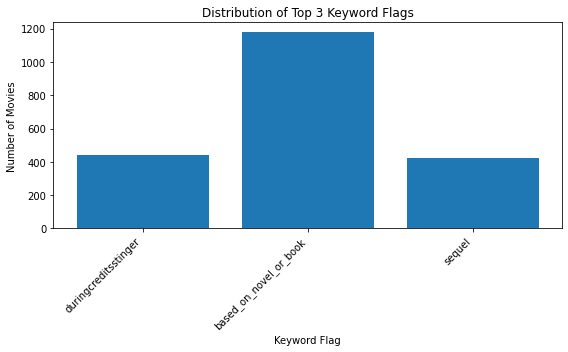

In [0]:
# Plot distribution of these boolean keyword flags
bool_cols_kw = [k.lower().replace(" ", "_").replace(".", "").replace(",", "") for k in top3_kw]
dist_kw = (
    df_copy3
      .select([spark_sum(col(c)).alias(c) for c in bool_cols_kw])
      .toPandas()
      .melt(var_name="keyword", value_name="count")
)
plt.figure(figsize=(8,5))
plt.bar(dist_kw["keyword"], dist_kw["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Top 3 Keyword Flags")
plt.ylabel("Number of Movies")
plt.xlabel("Keyword Flag")
plt.tight_layout()
plt.show()

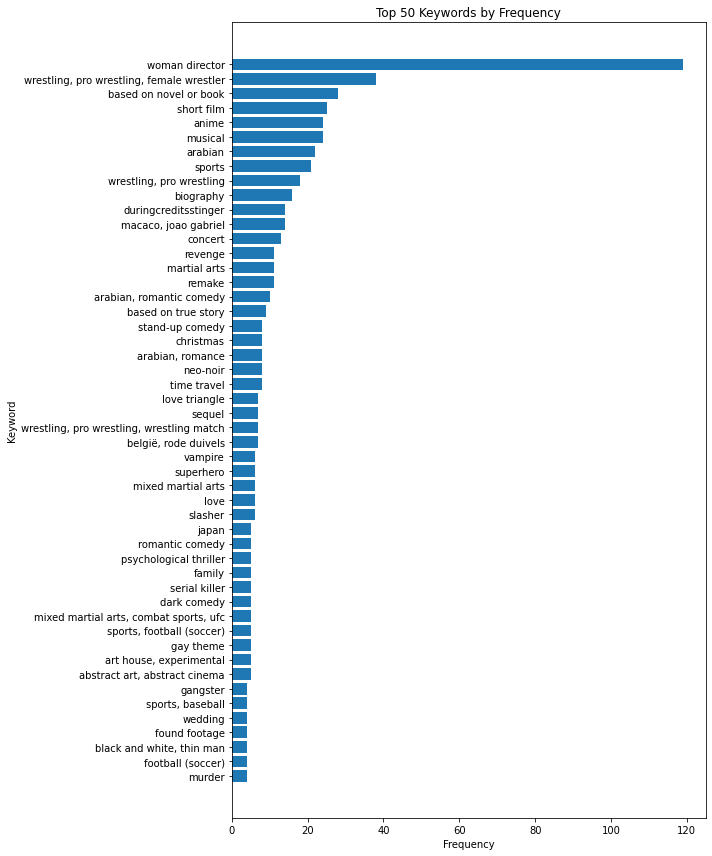

In [0]:
# Explode the 'keywords' string column into individual rows.
#    Adjust the delimiter in split() if your keywords are comma-separated, e.g. "," instead of "\\|"
keywords_exploded = df.select(
    explode(
        split(col("keywords"), "\\|")
    ).alias("keyword")
).filter(col("keyword") != "")

# 2) Count and take the top 50
top50 = (
    keywords_exploded
      .groupBy("keyword")
      .count()
      .orderBy(col("count").desc())
      .limit(50)
      .toPandas()
)

# 3) Plot as a horizontal bar chart with matplotlib
plt.figure(figsize=(10, 12))
plt.barh(top50["keyword"][::-1], top50["count"][::-1])
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.title("Top 50 Keywords by Frequency")
plt.tight_layout()
plt.show()


+-----------------------------------------+---------+------------------+
|keyword                                  |frequency|avg_revenue       |
+-----------------------------------------+---------+------------------+
|woman director                           |119      |4416426.470588235 |
|wrestling, pro wrestling, female wrestler|38       |54719.21052631579 |
|based on novel or book                   |28       |6832236.714285715 |
|short film                               |25       |69874.8           |
|anime                                    |24       |2.1115885125E7    |
|musical                                  |24       |7462412.833333333 |
|arabian                                  |22       |1276609.0         |
|sports                                   |21       |4175720.238095238 |
|wrestling, pro wrestling                 |18       |17078.444444444445|
|biography                                |16       |6609477.1875      |
+-----------------------------------------+--------

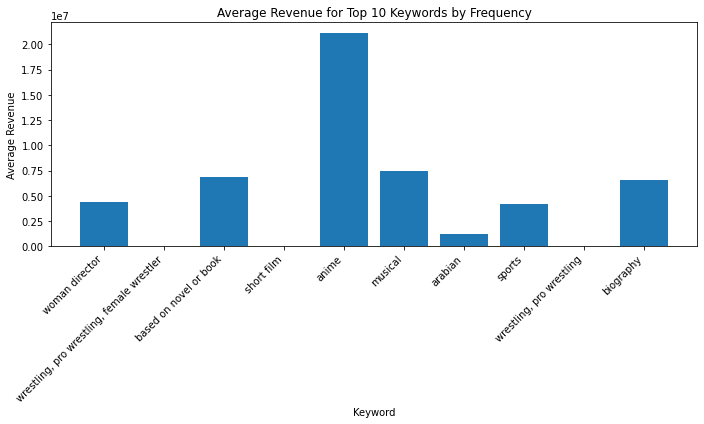

In [0]:
# 1) Explode keywords and carry revenue along
keywords_df = df.select(
    explode(split(col("keywords"), "\\|")).alias("keyword"),
    col("revenue").cast("double")
).filter(col("keyword") != "")

# 2) Compute frequency and average revenue per keyword
kw_stats = (
    keywords_df
      .groupBy("keyword")
      .agg(
          count("*").alias("frequency"),
          avg("revenue").alias("avg_revenue")
      )
)

# 3) Take top 10 keywords by frequency
top10 = (
    kw_stats
      .orderBy(col("frequency").desc())
      .limit(10)
)

# 4) Show the results in Spark
top10.show(truncate=False)

# 5) (Optional) Convert to Pandas and plot average revenue
pd_top10 = top10.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pd_top10["keyword"], pd_top10["avg_revenue"])
plt.xlabel("Keyword")
plt.ylabel("Average Revenue")
plt.title("Average Revenue for Top 10 Keywords by Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


%md
## New Features

%md
### Profit and ROI

In [0]:
# Filter out rows with zero or null budget or revenue to avoid division errors
df_money = df.filter((col("budget") > 0) & (col("revenue") > 0))

# Create 'profit' and 'roi' columns
df_money = df_money.withColumn("profit", col("revenue") - col("budget"))
df_money = df_money.withColumn("roi", col("revenue") / col("budget"))

In [0]:
# Describe the statistics for 'profit' and 'roi' columns in PySpark
df_money.describe(['profit', 'roi']).show()

+-------+--------------------+--------------------+
|summary|              profit|                 roi|
+-------+--------------------+--------------------+
|  count|               13970|               13970|
|   mean|3.2262308319470294E7|   362434.2078834928|
| stddev| 1.211609818344928E8|1.5684212263858201E7|
|    min|          -899999984|4.444444444444444E-9|
|    max|          2780000000|               1.0E9|
+-------+--------------------+--------------------+



%md
#### Check only de ROI > 0

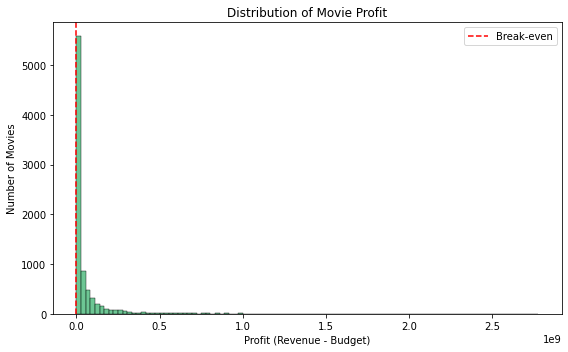

In [0]:
# Step 1: Calculate profit and ROI
df_money = df.withColumn("profit", col("revenue") - col("budget"))
df_money = df_money.withColumn("roi", col("revenue") / col("budget"))

# Step 2: Filter for positive profit and ROI
profit_roi_filtered = df_money.filter((col('profit') > 0) & (col('roi') > 0))

# Step 3: Convert to pandas DataFrame for plotting
profit_roi_filtered_pd = profit_roi_filtered.select('profit').toPandas()

# Step 4: Plot the distribution of profit
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(profit_roi_filtered_pd['profit'], bins=100, color='mediumseagreen')
plt.title('Distribution of Movie Profit')
plt.xlabel('Profit (Revenue - Budget)')
plt.ylabel('Number of Movies')
plt.axvline(0, color='red', linestyle='--', label='Break-even')
plt.legend()
plt.tight_layout()
plt.show()

%md
#### Movies with the highest profit

In [0]:
# Step 1: Sort by profit in descending order and get the top 10 movies
top_profit = profit_roi_filtered.orderBy(col('profit'), ascending=False).limit(10)

# Step 2: Select the relevant columns (title, revenue, budget, profit)
top_profit_selected = top_profit.select('title', 'revenue', 'budget', 'profit')

# Step 3: Convert to pandas DataFrame to display in a table
top_profit_selected_pd = top_profit_selected.toPandas()

# Step 4: Display the result
print(top_profit_selected_pd)

                          title     revenue     budget      profit
0                     Bee Movie  2930000000  150000000  2780000000
1             TikTok Rizz Party  3000000000  250000000  2750000000
2                        Avatar  2923706026  237000000  2686706026
3             Avengers: Endgame  2800000000  356000000  2444000000
4       Adventures in Bora Bora  3000000000  800000000  2200000000
5                   Best Of Joy  2000000000       1000  1999999000
6  Star Wars: The Force Awakens  2068223624  245000000  1823223624
7                Jurassic World  1671537444  150000000  1521537444
8                 The Lion King  1663075401  260000000  1403075401
9           O Negão do Banheiro  1345089061       1000  1345088061


%md
#### Movies with the highest ROI

In [0]:
# Step 1: Sort by ROI in descending order and get the top 10 movies
top_roi = profit_roi_filtered.orderBy(col('roi'), ascending=False).limit(10)

# Step 2: Select the relevant columns (title, budget, revenue, roi)
top_roi_selected = top_roi.select('title', 'budget', 'revenue', 'roi')

# Step 3: Convert to pandas DataFrame to display in a table
top_roi_selected_pd = top_roi_selected.toPandas()

# Step 4: Display the result
print(top_roi_selected_pd)


                              title  budget     revenue           roi
0             Pouring Out The Heart       1  1000000000  1.000000e+09
1  GEESE - THE MONEY TALKS TOUR '24       1  1000000000  1.000000e+09
2                ירידתם של המגניבים       1  1000000000  1.000000e+09
3                     Lil Detective       2   999999999  5.000000e+08
4                   חברים על סמים 2       5  1000000000  2.000000e+08
5                              דילן       5  1000000000  2.000000e+08
6                   חברים על סמים 1       5  1000000000  2.000000e+08
7                Żyraf: Czas Zemsty       1   100004215  1.000042e+08
8                         The Light       1   100000000  1.000000e+08
9                  A Cama do Macaco      10  1000000000  1.000000e+08


%md
## Correlation Matrix for Popularity, Vote_Count and Revenue

In [0]:
# Convert to pandas for correlation analysis
df_pd = df.select('popularity', 'vote_count', 'revenue').toPandas()

# Compute correlation matrix
correlation_popularity = df_pd.corr()

# Display the correlation matrix
print("Correlation between Popularity, Vote Count, and Revenue:")
print(correlation_popularity)

Correlation between Popularity, Vote Count, and Revenue:
            popularity  vote_count   revenue
popularity    1.000000    0.714679  0.502356
vote_count    0.714679    1.000000  0.657769
revenue       0.502356    0.657769  1.000000


%md
Vote count appears to have the strongest relationship with revenue.

Both popularity and vote count are positively correlated with revenue, but the relationship with popularity is weaker compared to the relationship between vote count and revenue.

In [0]:
# To check the type of each feature
df.printSchema()
# Function to calculate missing values by column
def missing_values_table_spark(df):
    """
    Calculates the total number and percentage of missing (null) values 
    for each column in a PySpark DataFrame.

    Returns a Pandas DataFrame with columns:
    - 'Column': column name
    - 'Missing Values': count of missing values
    - '% of Total Values': percentage of missing values
    
    Only columns with missing values are included, sorted in descending order.
    """
    # Calculate the total missing values for each column
    mis_val = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])

    # Convert to Pandas for easier handling
    mis_val_pd = mis_val.toPandas().transpose()

    # Calculate the percentage of missing values for each column
    mis_val_percent = (mis_val_pd[0] / df.count()) * 100

    # Create a new table combining count and percentage
    mis_val_table = pd.concat([mis_val_pd, mis_val_percent], axis=1)
    mis_val_table.columns = ['Missing Values', '% of Total Values']

    # Keep only columns with >0% missing, sort descending, round
    mis_val_table = (
        mis_val_table[mis_val_table['% of Total Values'] > 0]
        .sort_values('% of Total Values', ascending=False)
        .round(1)
    )

    # Reset index so that original column names become a column
    mis_val_table = mis_val_table.reset_index().rename(columns={'index': 'Column'})

    # Print summary
    print(f"Your selected dataframe has {len(df.columns)} columns.\n"
          f"There are {mis_val_table.shape[0]} columns that have missing values.")

    return mis_val_table

# Usage
missing_values = missing_values_table_spark(df)
display(missing_values)

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- budget: long (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- release_day: integer (nullable = true)
 |-- release_month: integer (nullable = true)
 |-- release_year: integer (nu

Column,Missing Values,% of Total Values
tagline,7278,35.6
keywords,5580,27.3
vote_average,3806,18.6
imdb_id,3674,18.0
production_companies,3661,17.9
production_countries,3223,15.8
spoken_languages,2619,12.8
release_date,1942,9.5
release_day,1935,9.5
release_month,1935,9.5


%md
### Save the DataSet

In [0]:
df = df_copy3

In [0]:
# to save our dataset
df.write.mode("overwrite").parquet("/FileStore/tables/Imdb_Movie_Dataset-4.csv")
display(df.limit(5))

org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3829.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3829.0 (TID 15187) (ip-10-172-227-209.us-west-2.compute.internal executor driver): com.databricks.sql.io.FileReadException: Error while reading file dbfs:/FileStore/tables/Imdb_Movie_Dataset-4.csv/part-00000-tid-881561469118013476-2bd8934e-0d81-4da2-9688-3fd8495c6909-14160-1-c000.snappy.parquet. [DEFAULT_FILE_NOT_FOUND] It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved. If disk cache is stale or the underlying files have been removed, you can invalidate disk cache manually by restarting the cluster.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1$$anon$2.logFileNameAndThrow(FileScanRDD.scala:704)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1$$anon$2.getNext(FileScanRDD.scala:646)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.$anonfun$prepareNextFile$1(FileScanRDD.scala:879)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingRunnable.$anonfun$run$1(SparkThreadLocalForwardingThreadPoolExecutor.scala:116)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.spark.util.IdentityClaim$.withClaim(IdentityClaim.scala:48)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingHelper.$anonfun$runWithCaptured$4(SparkThreadLocalForwardingThreadPoolExecutor.scala:79)
	at com.databricks.unity.UCSEphemeralState$Handle.runWith(UCSEphemeralState.scala:41)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingHelper.runWithCaptured(SparkThreadLocalForwardingThreadPoolExecutor.scala:78)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingHelper.runWithCaptured$(SparkThreadLocalForwardingThreadPoolExecutor.scala:64)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingRunnable.runWithCaptured(SparkThreadLocalForwardingThreadPoolExecutor.scala:113)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingRunnable.run(SparkThreadLocalForwardingThreadPoolExecutor.scala:116)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.io.FileNotFoundException: /FileStore/tables/Imdb_Movie_Dataset-4.csv/part-00000-tid-881561469118013476-2bd8934e-0d81-4da2-9688-3fd8495c6909-14160-1-c000.snappy.parquet
	at com.databricks.backend.daemon.data.client.DbfsClient.send0(DbfsClient.scala:121)
	at com.databricks.backend.daemon.data.client.DbfsClient.sendIdempotent(DbfsClient.scala:69)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV1.getFileStatus(DatabricksFileSystemV1.scala:272)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystem.getFileStatus(DatabricksFileSystem.scala:212)
	at com.databricks.spark.metrics.FileSystemWithMetrics.getFileStatus(FileSystemWithMetrics.scala:399)
	at com.databricks.sql.io.parquet.CachingParquetFooterReader.readFooter(CachingParquetFooterReader.java:203)
	at com.databricks.sql.io.parquet.CachingParquetFileReader.readFooter(CachingParquetFileReader.java:412)
	at org.apache.spark.sql.execution.datasources.parquet.SpecificParquetRecordReaderBase.prepare(SpecificParquetRecordReaderBase.java:157)
	at org.apache.spark.sql.execut